In [12]:
import pickle
import os

FOLDER = os.getcwd() + "/4_pts_blurry"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time
from utils import *
from Dataloader import *
from PSFNet import *

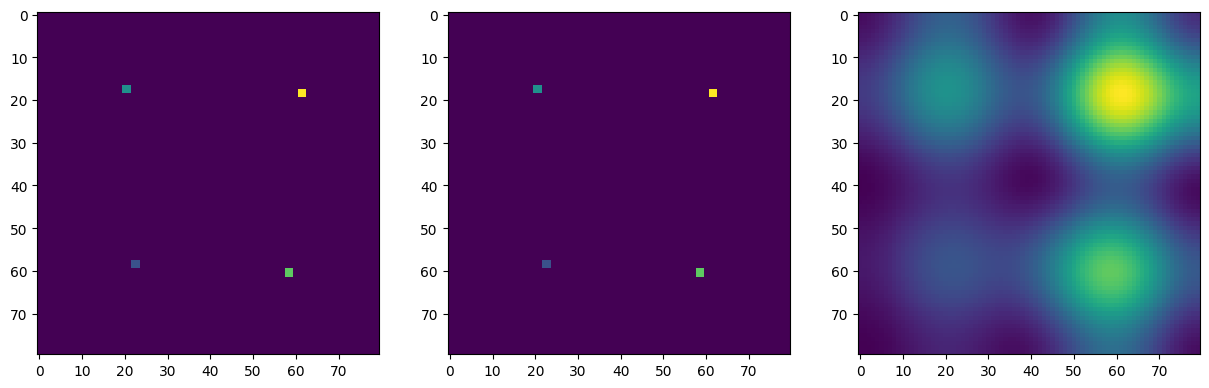

In [14]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
maskSize = EuclideanDistance((0,0),mask.shape)
sourcePts = GetSourcePts(mask,FOLDER)

#Define dataset and dataloader
dataset = Dataloader(out, mask)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

#Define model
model = PSFNet(len(dataset),16,dataset.intensityMatrix.data.flatten())

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [17]:
#Training loop

timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"
oldOut = out.copy()

TrainingLoop(model,dataloader,criterion,optimizer,epochs=100)
oldOut = InverseMatrix(oldOut,mask,sourcePts,model,learningRate=0.5)
oldOut = oldOut/max(oldOut.flatten())
dataloader = Dataloader(oldOut, mask)
TrainingLoop(model,dataloader,criterion,optimizer,epochs=100)
oldOut = InverseMatrix(oldOut,mask,sourcePts,model,learningRate=0.5)
oldOut = oldOut/max(oldOut.flatten())
dataloader = Dataloader(oldOut, mask)
TrainingLoop(model,dataloader,criterion,optimizer,epochs=100)
oldOut = InverseMatrix(oldOut,mask,sourcePts,model,learningRate=0.5)
oldOut = oldOut/max(oldOut.flatten())
dataloader = Dataloader(oldOut, mask)
TrainingLoop(model,dataloader,criterion,optimizer,epochs=100)
oldOut = InverseMatrix(oldOut,mask,sourcePts,model,learningRate=0.5)
oldOut = oldOut/max(oldOut.flatten())

print('Finished Training')

plt.imshow(out)


Epoch:  1  Loss:  69.07893371582031
Epoch:  21  Loss:  43.67731475830078
Epoch:  41  Loss:  29.134723663330078
Epoch:  61  Loss:  23.145490646362305
Epoch:  81  Loss:  19.929035186767578
Epoch:  100  Loss:  17.936792373657227
[0.5, 1.0, 0.25, 0.75]
[[0.26368147]
 [1.        ]
 [0.00715472]
 [0.50514508]]


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

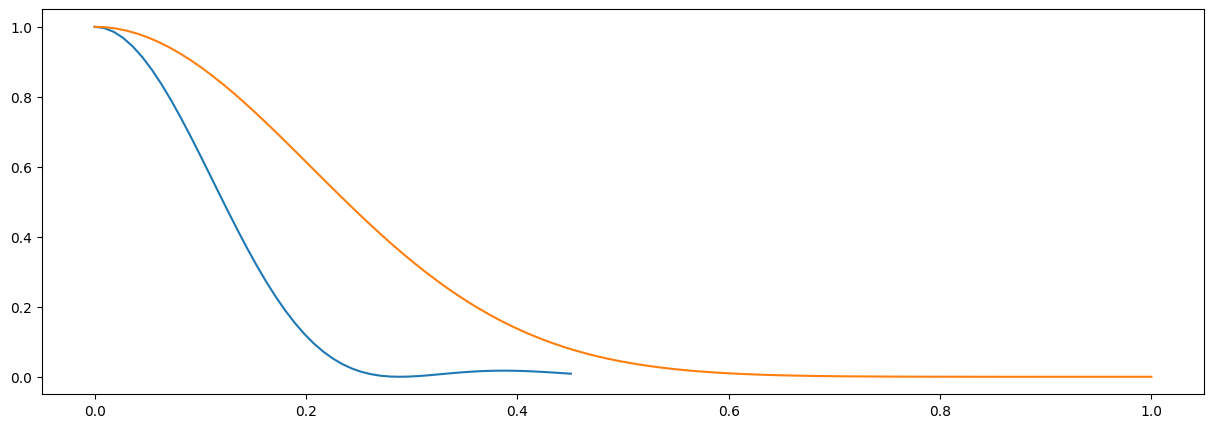

In [ ]:
#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))*len(original_psf)/maskSize
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
plt.plot(new_psf_x,new_psf_y)
plt.show()


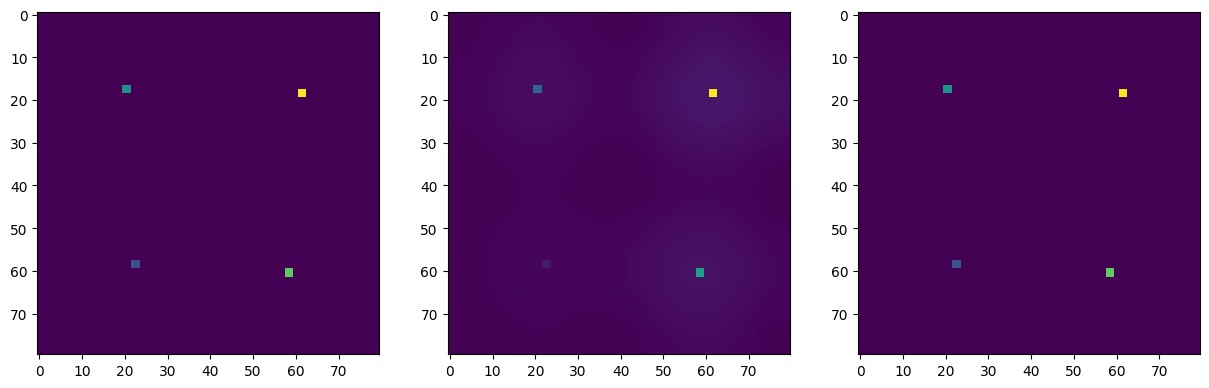

In [ ]:
#Recreate original image based off of calculated intensity

customOriginal = np.zeros(mask.shape)
modelIntensity = model.actual_intensity.weight.data[0]
for i in range(len(modelIntensity)):
    customOriginal[sourcePts[i][0]][sourcePts[i][1]] = modelIntensity[i]

oriNormalised = np.asanyarray(ori)
oriNormalised = oriNormalised / max(oriNormalised.flatten())

outNormalised = np.asanyarray(out)
outNormalised = outNormalised / max(outNormalised.flatten())

customOriginal = customOriginal / max(customOriginal.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(oriNormalised)
axarr[1].imshow(outNormalised)
axarr[2].imshow(customOriginal)
plt.show()


array([[1.        , 0.99998284],
       [0.99998284, 1.        ]])

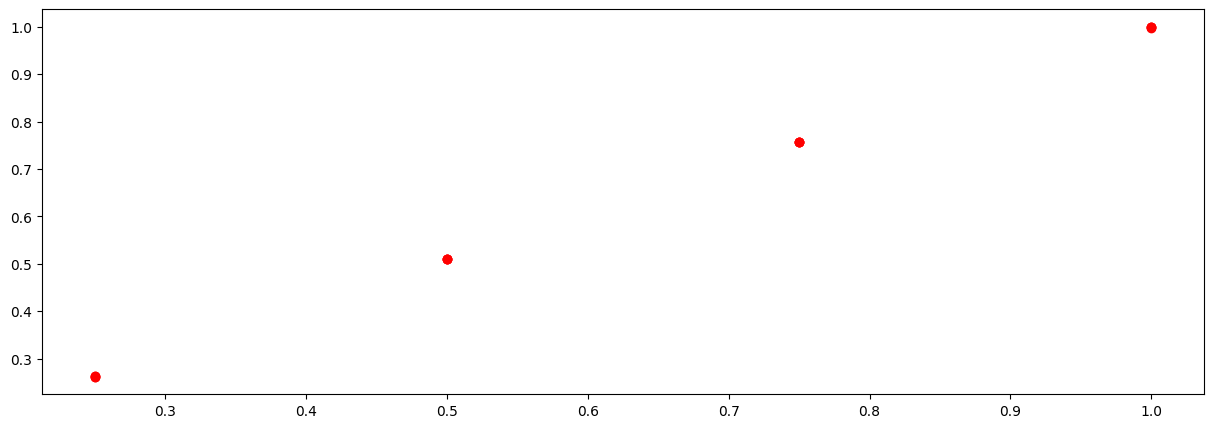

In [ ]:
original_intensity = []
custom_intensity = []

for i in range(len(modelIntensity)):
    original_intensity.append(oriNormalised[sourcePts[i][0]][sourcePts[i][1]])
    custom_intensity.append(customOriginal[sourcePts[i][0]][sourcePts[i][1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)